In [1]:
!pip3 install ensemble_boxes

  Using cached ensemble_boxes-1.0.8-py3-none-any.whl (21 kB)
     |████████████████████████████████| 11.7 MB 14.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.4 MB 72.6 MB/s eta 0:00:01
     |████████████████████████████████| 34.5 MB 64.5 MB/s eta 0:00:01


In [2]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

In [3]:
# ensemble csv files
submission_files = ["/opt/ml/0.5711.csv", # yolov5x6_1024_aug1_12batch_coslr_tta.
                    "/opt/ml/0.5979.csv",
                    "/opt/ml/0.6172.csv",
                    "/opt/ml/0.6384.csv",
                    "/opt/ml/0.6704.csv",
                    "/opt/ml/0.5614.csv",
                    "/opt/ml/0.6032.csv",
                    "/opt/ml/0.6166.csv",
                    "/opt/ml/0.5703.csv",
                    "/opt/ml/submission/yolov5x6_cv04_cleandata.csv",
                    "/opt/ml/submission/yolov5x6_cv04_cleandata_fold2.csv",
                    "/opt/ml/submission/yolov5x6_cv04_cleandata_fold4.csv",
                    "/opt/ml/remove1.csv",
                    "/opt/ml/remove2.csv",
                    "/opt/ml/remove3.csv",
                    "/opt/ml/univ_ensemble1.csv",
                  ] # submission csv 파일 이름을 넣어주세요


submission_df = [pd.read_csv(file) for file in submission_files]

In [4]:
image_ids = [f'test/{str(idx).zfill(4)}.jpg' for idx in range(4871)]# submission_df[0]['image_id'].tolist()

In [5]:
annotation = '/opt/ml/detection/dataset/test.json'
coco = COCO(annotation)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [6]:
from tqdm import tqdm
prediction_strings = []
file_names = []
iou_thr = 0.4
skip_box_thr=0
conf_type = 'avg' # 'avg', 'max', 'box_and_model_avg', 'absent_model_aware_avg'
'''
param conf_type: how to calculate confidence in weighted boxes.
    'avg': average value,
    'max': maximum value,
    'box_and_model_avg': box and model wise hybrid weighted average,
    'absent_model_aware_avg': weighted average that takes into account the absent model.
'''

for i, image_id in enumerate(tqdm(image_ids)):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    
    for df in submission_df:
        if df[df['image_id'] == image_id]['PredictionString'].tolist():
            predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
            predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        # boxes, scores, labels = nms(boxes_list, scores_list, labels_list,iou_thr=iou_thr)
        # boxes, scores, labels = soft_nms(box_list, scores_list, labels_list, iou_thr=iou_thr)
        # boxes, scores, labels = non_maximum_weighted(boxes_list, scores_list, labels_list,iou_thr=iou_thr)
        # boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list,iou_thr=0.5,conf_type='box_and_model_avg')
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

  0%|          | 1/4871 [00:00<15:06,  5.37it/s]/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
  0%|          | 6/4871 [00:00<08:49,  9.19it/s]/opt/conda/envs/detection/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
100%|██████████| 4871/4871 [08:26<00:00,  9.61it/s]


In [7]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('/opt/ml/model_ensemble/final.csv', index = False)

submission

,PredictionString,image_id
0,7 0.708520233631134 217.2733917236328 51.22336...,test/0000.jpg
1,4 0.18249274790287018 345.2569885253906 247.37...,test/0001.jpg
2,4 0.3319348990917206 867.6079711914062 245.205...,test/0002.jpg
3,9 0.17329031229019165 109.95124816894531 194.7...,test/0003.jpg
4,1 0.19561827182769775 201.5937957763672 276.00...,test/0004.jpg
...,...,...
4866,1 0.17934347689151764 294.8795471191406 348.32...,test/4866.jpg
4867,3 0.16529372334480286 412.2421875 320.36853027...,test/4867.jpg
4868,7 0.25934433937072754 119.32098388671875 461.8...,test/4868.jpg
4869,0 0.21969425678253174 7.718214511871338 235.70...,test/4869.jpg


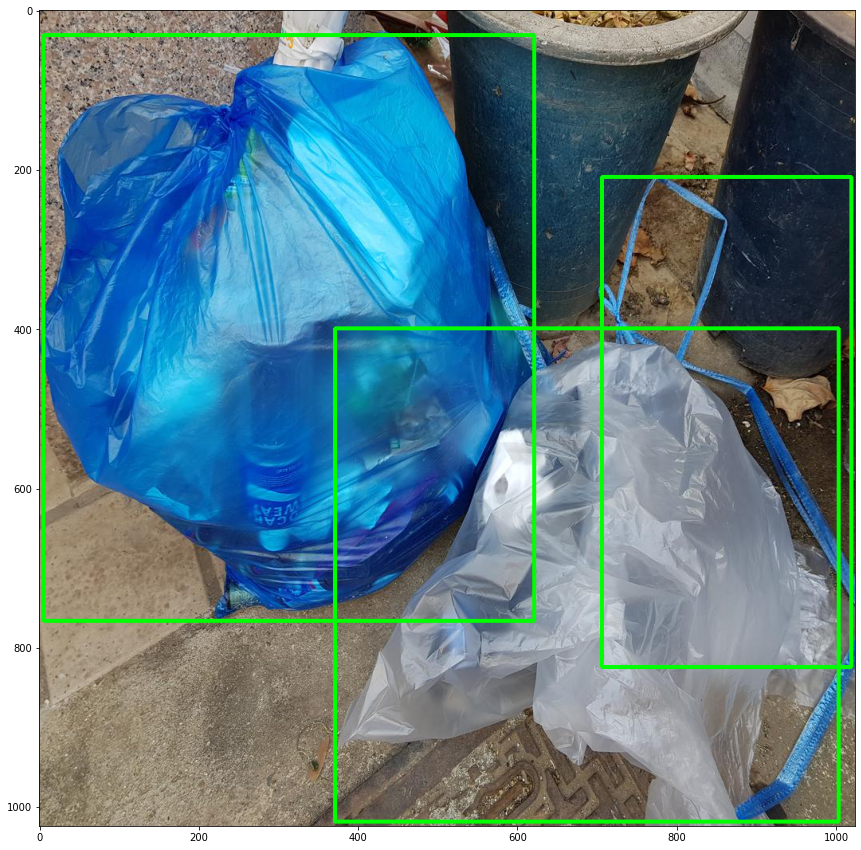

In [171]:
import matplotlib.pyplot as plt
import cv2

index = 190
img = plt.imread(f"/opt/ml/detection/dataset/test/{str(index).zfill(4)}.jpg")

elements = submission.PredictionString[index].split()
i=0
while i<len(elements):
    label, score, x1, y1, x2, y2 = elements[i:i+6]
    if float(score) < 0.3:
        i+=6
        continue
    x1 = int(float(x1))
    y1 = int(float(y1))
    x2 = int(float(x2))
    y2 = int(float(y2))
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    i += 6

plt.figure(figsize=(15,15))
plt.imshow(img)